In [8]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [9]:
classificators = [
#     ("LGBMClassifier", LGBMClassifier, SEARCH_SPACE_LGBM, LIGHTGBM_PARAMS),
#     ("XGBClassifier", XGBClassifier, SEARCH_SPACE_XGB, XGBOOST_PARAMS),
    ("TABNETClassifier", TabNetClassifier, SEARCH_SPACE_TABNET, TABNET_PARAMS),
]

In [10]:
data = pd.read_csv("data/census_income/train.csv")

In [11]:
X = data.drop(["TARGET"], axis=1).values
y = data["TARGET"].values

In [12]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=True)

In [13]:
def BayesianOptimization(clf, params, search_range, model_name):
    def func_gb(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], early_stopping_rounds=10, verbose=0)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    def func_tabnet(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], max_epochs=30)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    return func_gb if model_name != "TABNETClassifier" else func_tabnet

In [14]:
results = dict()
for clf_name, clf, search_range, params in classificators:
    res_gp = gp_minimize(BayesianOptimization(clf, params, search_range, clf_name), search_range, n_jobs=-1, verbose=True, n_random_starts=10, n_calls=30)
    results[clf_name] = res_gp
    with open('{}_res_gp.pickle'.format(clf_name), 'wb') as f:
        pickle.dump(data, f)

Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': False, 'gamma': 1.0376772020454097, 'lambda_sparse': 0.039928237624156156, 'n_steps': 4, 'n_a': 32, 'n_d': 32}

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.90822
Best weights from best epoch are automatically used!
AUC:  0.908223  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 83.5610
Function value obtained: -0.9082
Current minimum: -0.9082
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': False, 'gamma': 1.506890211137065, 'lambda_sparse': 0.04358101743892918, 'n_steps': 5, 'n_a': 40, 'n_d': 40}
Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_auc = 0.9055
Best weights from best epoch are automatically used!
AUC:  0.9055  of boosting iteration 
Iteration No: 2 ended. Evaluation do

AUC:  0.910661  of boosting iteration 
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 99.9303
Function value obtained: -0.9107
Current minimum: -0.9127
Iteration No: 16 started. Searching for the next optimal point.

Testing next set of paramaters... {'seed': 42, 'verbose': False, 'gamma': 1.2625191437210406, 'lambda_sparse': 0.011940600659062026, 'n_steps': 3, 'n_a': 32, 'n_d': 32}
Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_auc = 0.91098
Best weights from best epoch are automatically used!
AUC:  0.910976  of boosting iteration 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 95.6978
Function value obtained: -0.9110
Current minimum: -0.9127
Iteration No: 17 started. Searching for the next optimal point.

Testing next set of paramaters... {'seed': 42, 'verbose': False, 'gamma': 1.2657371678860991, 'lambda_sparse': 0.0978158176104867, 'n_steps': 10, 'n_a': 16, 'n_d': 16}
Stop train

Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.90421
Best weights from best epoch are automatically used!
AUC:  0.904207  of boosting iteration 
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 77.1369
Function value obtained: -0.9042
Current minimum: -0.9127


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

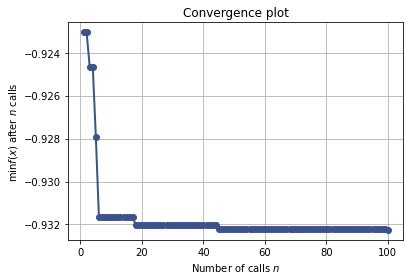

In [13]:
plot_convergence(results["XGBClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

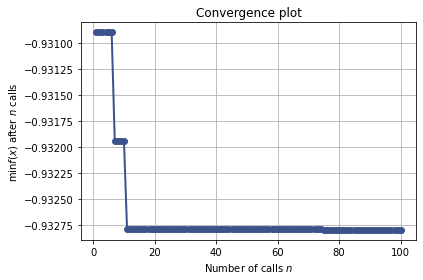

In [14]:
plot_convergence(results["LGBMClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

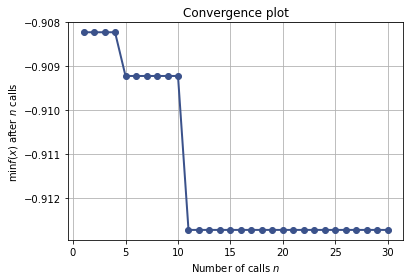

In [15]:
plot_convergence(results["TABNETClassifier"])

In [15]:
results["LGBMClassifier"].x

[0.10284216487315759, 4, 955]

In [16]:
results["XGBClassifier"].x

[0.3317433223693123, 4, 772]

In [16]:
results["TABNETClassifier"].x

[1.0131059206061017, 0.0051151725754103195, 10, 54]